In [1]:
import os
import torch
import torchvision
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
from collections import OrderedDict

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

device_count = torch.cuda.device_count()
for i in range(device_count):
    device_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {device_name}")

GPU 0: NVIDIA GeForce RTX 3090
GPU 1: NVIDIA GeForce RTX 3090


In [3]:
## load device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device : {DEVICE}")

## create dataset save location
PATH = "./mnist/"
if os.path.exists(PATH):
    print(f"The directory '{PATH}' already exists.")
else:
    os.mkdir(PATH)
    print(f"The directory '{PATH}' successfully created.")

Current Device : cuda
The directory './mnist/' already exists.


In [4]:
## hyperparameters
EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.005
INPUT_SIZE = 28*28

In [5]:
## Data preparation
totensor = torchvision.transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root=PATH, train=True, download=True, transform=totensor)
testset = torchvision.datasets.MNIST(root=PATH, train=False, download=True, transform=totensor)

if device_count == 1:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, 
                                              shuffle=True, num_workers=device_count)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=device_count)

In [6]:
## show some samples
def plot_dataset(dataloader, grid_width, grid_height, figure_width, figure_height):
    images, labels = next(iter(dataloader))
    fig, ax = plt.subplots(grid_height, grid_width)
    fig.set_size_inches(figure_width, figure_height)
    for i in range(grid_height):
        for j in range(grid_width):
            img_idx = np.random.choice(np.arange(BATCH_SIZE), replace=False)
            image, label = images[img_idx], labels[img_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label.item(), color='black')
            ax[i][j].imshow(image.squeeze(), cmap='gray')
        plt.subplots_adjust(hspace=0.25)
    plt.tight_layout()
    plt.show()

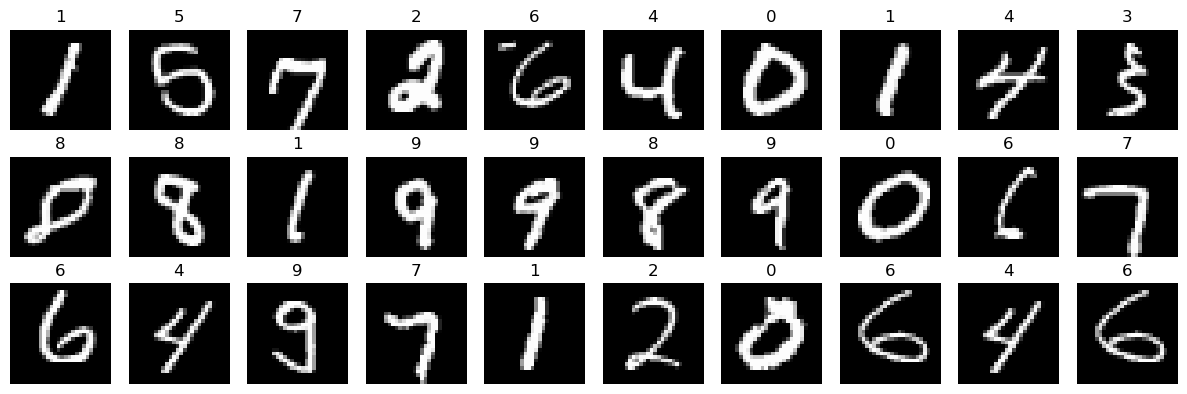

In [7]:
plot_dataset(trainloader, grid_width=10, grid_height=3, figure_width=12, figure_height=4)

In [8]:
## Naive Autoencoder
class AutoEncoder(nn.Module):
    ## Two-FC-layer encoder and decoder
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.input_size = 28 * 28
        self.hidden1 = 512
        self.hidden2 = 64
        
        self.fc1 = nn.Linear(self.input_size, self.hidden1)
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        
        self.fc3 = nn.Linear(self.hidden2, self.hidden1)
        self.fc4 = nn.Linear(self.hidden1, self.input_size)

    def encode(self, x):
        x = x.view(-1, self.input_size)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    def decode(self, x):
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

In [9]:
## loss functions and optimizer
LOSS_FUNCTIONS = ['BCE', 'MSE', 'MAE']
OPTIMIZERS = {
    'sgd': torch.optim.SGD, 
    'rmsprop': torch.optim.RMSprop, 
    'adagrad': torch.optim.Adagrad, 
    'adam': torch.optim.Adam, 
    'adamax': torch.optim.Adamax,
    'adadelta': torch.optim.Adadelta,
}

In [10]:
def train(epoch, model, loss_function, train_loader, optimizer, verbose=False):
    assert loss_function in LOSS_FUNCTIONS
    model.train()
    train_loss = 0
    batch_idx = 0
    for image, _ in train_loader:
        image = image.to(DEVICE)
        
        ## initialize the optimizer
        optimizer.zero_grad()
        
        ## decoded output
        decoded = model(image)
        
        ## compute loss for each batch
        if loss_function == "BCE":
            loss = F.binary_cross_entropy(decoded, image.view(-1, INPUT_SIZE))
        elif loss_function == "MSE":
            loss = F.mse_loss(decoded, image.view(-1, INPUT_SIZE))
        else:
            loss = F.l1_loss(decoded, image.view(-1, INPUT_SIZE))
        
        ## accumulate the total train loss during the epoch and backpropagation
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        ## Check training status
#         if batch_idx % 100 == 0:
#             print(f'Train Epoch: {epoch} [{batch_idx*len(image)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\t Loss: {loss.item()/len(image):.6f}')
        
        batch_idx += 1

    if verbose:
        print(f"Epoch: {epoch} Average training loss: {train_loss / len(train_loader.dataset):.6f}")
    
    return train_loss / len(train_loader.dataset)


def test(epoch, model, loss_function, test_loader, verbose=False):
    model.eval()
    test_loss = 0
    batch_idx = 0
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.to(DEVICE)
            decoded = model(image)

            ## compute loss for each batch
            if loss_function == "BCE":
                loss = F.binary_cross_entropy(decoded, image.view(-1, INPUT_SIZE))
            else:
                loss = F.mse_loss(decoded, image.view(-1, INPUT_SIZE))
            
            test_loss += loss.item()
        
        if verbose:
            print(f"Epoch: {epoch} Average test loss: {test_loss / len(test_loader.dataset):.6f}")
    
    return test_loss / len(test_loader.dataset)


In [11]:
def run(num_devices, loss_fn, optim_name, verbose1=False, verbose2=True, save_model=False):
    if num_devices == 1:
        model = AutoEncoder().to(DEVICE)
    else:
        device_ids = list(np.arange(num_devices))
        model = nn.DataParallel(AutoEncoder(), device_ids=device_ids).to(DEVICE)

    optimizer = OPTIMIZERS[optim_name](model.parameters(), lr=LEARNING_RATE)
    
    train_losses = np.zeros(EPOCHS)
    test_losses = np.zeros(EPOCHS)
    for epoch in tqdm(range(EPOCHS)):
        train_loss = train(epoch, model, loss_fn, trainloader, optimizer, verbose=verbose1)
        test_loss = test(epoch, model, loss_fn, testloader, verbose=verbose1)
        
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss
        
    if verbose2:
        print(f"{loss_fn}\tTraining loss: {train_loss:.6f}\tTest loss: {test_loss:.6f}")
        
    if save_model:
        saved_model = model.state_dict()
        fname = f"./saved_model_{loss_fn}.pt"
        torch.save(saved_model, fname)

In [12]:
for loss_fn in LOSS_FUNCTIONS:
    run(device_count, loss_fn, "adam", verbose2=True, save_model=True)

  0%|          | 0/20 [00:00<?, ?it/s]

BCE	Training loss: 0.000574	Test loss: 0.000580


  0%|          | 0/20 [00:00<?, ?it/s]

MSE	Training loss: 0.000042	Test loss: 0.000045


  0%|          | 0/20 [00:00<?, ?it/s]

MAE	Training loss: 0.000244	Test loss: 0.000126


In [13]:
## Comparison between the ground truth and re-constructed image
def model_comparison(loss_fn, indices, dataloader, grid_width, grid_height, figure_width, figure_height):
    images, labels = next(iter(dataloader))
    
    ## show ground truth
    fig, ax = plt.subplots(grid_height, grid_width)
    fig.set_size_inches(figure_width, figure_height)
    for i in range(grid_height):
        for j in range(grid_width):
            img_idx = indices[i*grid_width + j]
            image, label = images[img_idx], labels[img_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label.item(), color='black')
            ax[i][j].imshow(image.squeeze(), cmap='gray')
        plt.subplots_adjust(hspace=0.25)
    plt.tight_layout()
    plt.show()
    
    ## load the trained model
    model = AutoEncoder()
    checkpoint = torch.load(f'saved_model_{loss_fn}.pt')
    state_dict = OrderedDict()
    for key, value in checkpoint.items():
        key = key.replace('module.', '')
        state_dict[key] = value
    model.load_state_dict(state_dict)
    model.eval()
    
    ## show the re-constructed images
    fig, ax = plt.subplots(grid_height, grid_width)
    fig.set_size_inches(figure_width, figure_height)
    for i in range(grid_height):
        for j in range(grid_width):
            img_idx = indices[i*grid_width + j]
            image, label = images[img_idx], labels[img_idx]
            decoded = model(image).detach().numpy()

            ax[i][j].axis('off')
            ax[i][j].set_title(label.item(), color='black')
            ax[i][j].imshow(decoded.reshape(28, 28), cmap='gray')
        plt.subplots_adjust(hspace=0.25)
    plt.tight_layout()
    plt.show()

BCE


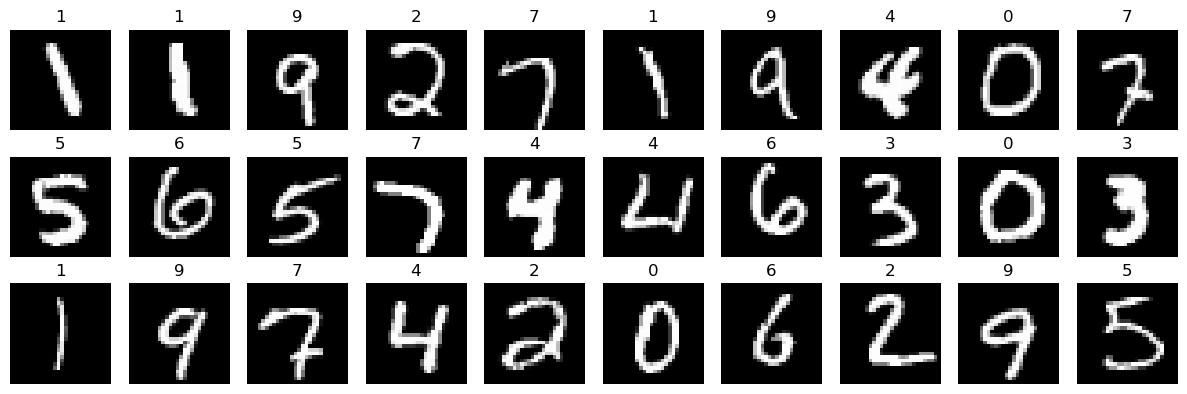

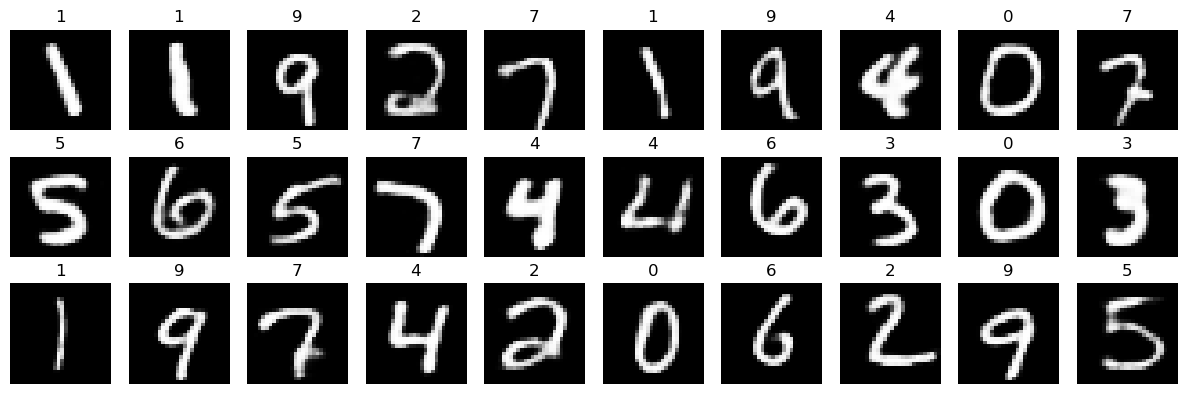

MSE


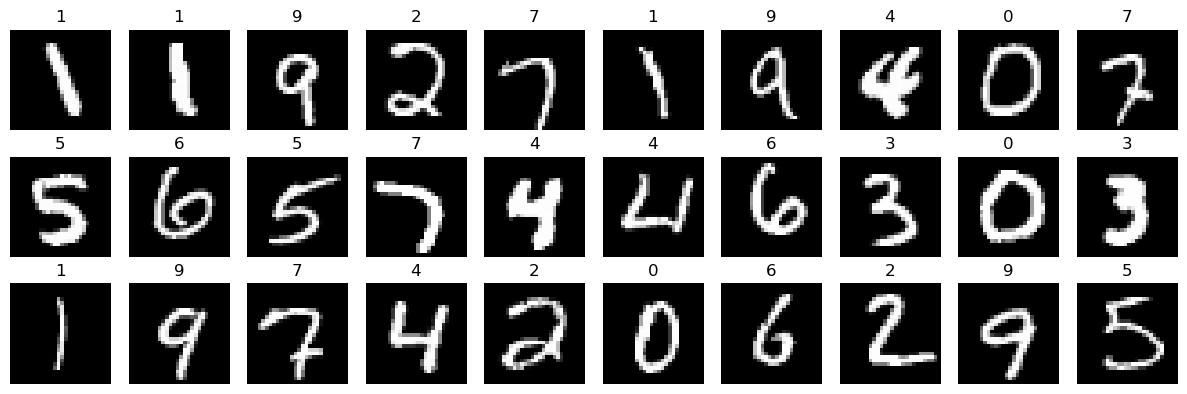

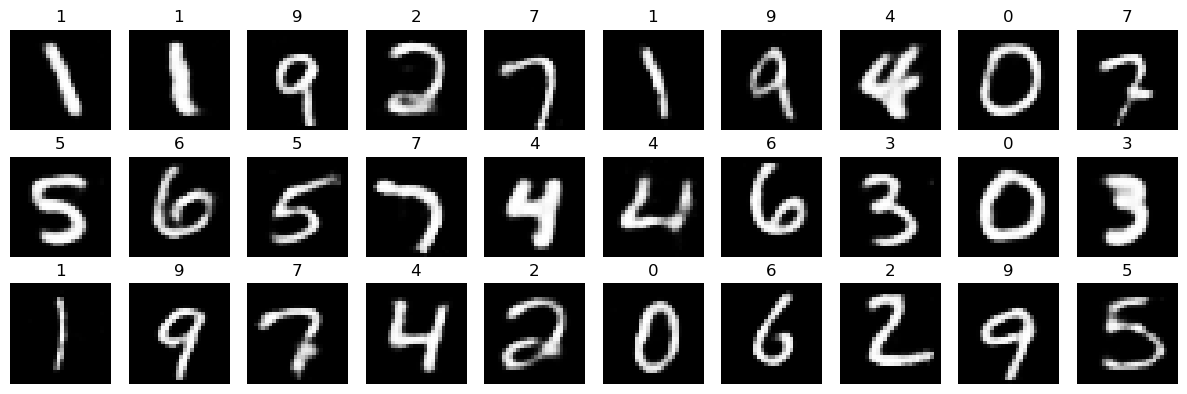

MAE


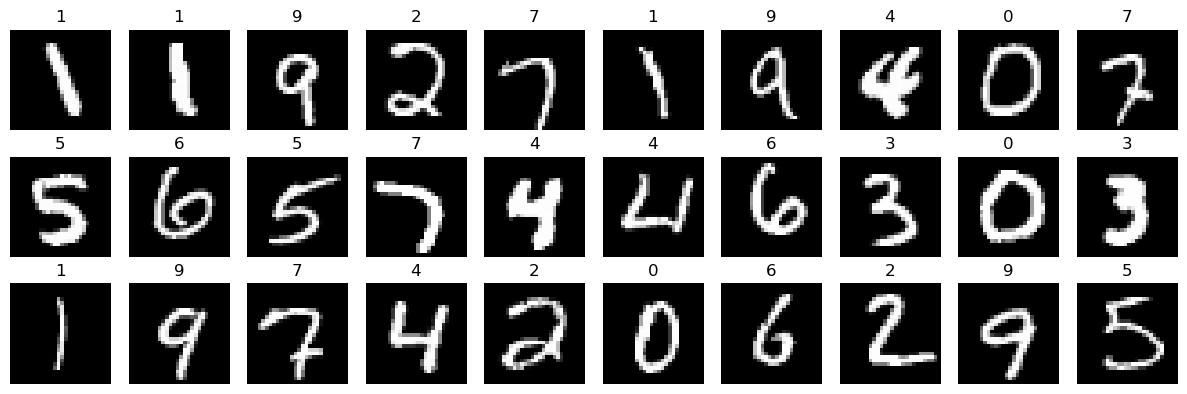

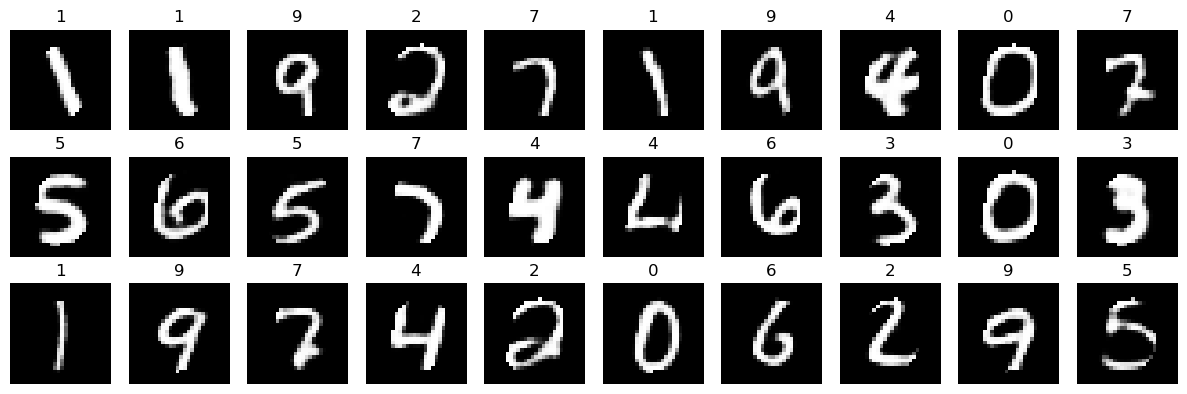

In [14]:
grid_width, grid_height = 10, 3
figure_width, figure_height = 12, 4
indices = np.random.choice(np.arange(BATCH_SIZE), replace=False, size=grid_height*grid_width)
sampleloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, 
                                           shuffle=False, num_workers=device_count)

for loss_fn in LOSS_FUNCTIONS:
    print(loss_fn)
    model_comparison(loss_fn, indices, sampleloader, grid_width, grid_height, figure_width, figure_height)